In [1]:
import tensorflow as tf
import numpy as np
import torch
import torchvision as tv
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

2023-02-11 22:11:03.603726: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
sim_Input = 20 * torch.rand((1000, 1)) - 10
groundTruth = np.cos(sim_Input)

In [3]:
def calcParams(inputModel):
    val = sum(params.numel() for params in inputModel.parameters() if params.requires_grad)
    return val

In [4]:
class Optimize_NN_(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 3)
        self.fc2 = nn.Linear(3, 5)
        self.fc3 = nn.Linear(5, 1)

    def forward(self, val):
        val = F.relu(self.fc1(val))
        val = F.relu(self.fc2(val))
        val = self.fc3(val)
        return val

In [5]:
opt_Net = Optimize_NN_()
costFunc = nn.MSELoss()
opt = optim.Adam(opt_Net.parameters(), lr=0.001)

In [6]:
trainingIter = 8
EPOCHS = 30 
epochNum = round(EPOCHS / 3)
Layer1Connections = 3
layer2Connections = 15
layer3Connections = 5
tot_Model_Connections_ = Layer1Connections + layer2Connections + layer3Connections

costList = []
count = 0
layer2WeightsTensor = torch.zeros((trainingIter * epochNum, layer2Connections))
wholeModelWeightsTensor = torch.zeros((trainingIter * epochNum, tot_Model_Connections_))
cost_Tensor_ = torch.zeros((trainingIter * epochNum, 1))
for trainingIndex in range(trainingIter): 
    
    opt_Net = Optimize_NN_()
    costFunc = nn.MSELoss()
    opt = optim.Adam(opt_Net.parameters(), lr=0.001)
    for epochIndex in range(EPOCHS):
        opt_Net.zero_grad()
        output = opt_Net(sim_Input)
        cost = costFunc(output, groundTruth)
        cost.backward()
        opt.step()

        if epochIndex % 3 == 0:
            layer1Weights = torch.reshape(torch.flatten(opt_Net.fc1.weight), (1, Layer1Connections))
            layer2Weights = torch.reshape(torch.flatten(opt_Net.fc2.weight), (1, layer2Connections))
            layer3Weights = torch.reshape(torch.flatten(opt_Net.fc3.weight), (1, layer3Connections))
            
            tmp = torch.cat((layer2Weights, layer1Weights), dim=1)
            
            wholeModelWeights = torch.cat((tmp, layer3Weights), dim=1)
            wholeModelWeightsTensor[count] = wholeModelWeights
            layer2WeightsTensor[count] = layer2Weights
            cost_Tensor_[count] = cost
            count += 1

In [7]:
def pcaImplementation(inputArray, dimToReturn):
    m, n = inputArray.shape
    
    means_Of_Inputs_ = np.array([np.mean(inputArray[:, index]) for index in range(n)])
    inputNormalized = inputArray - means_Of_Inputs_
    
    mat1 = np.dot(np.transpose(inputNormalized),inputNormalized)
    eigenvalues, eigenvectors = np.linalg.eig(mat1)
    pairs = [(np.abs(eigenvalues[index]), eigenvectors[:, index]) for index in range(n)]

    pairs.sort(key=lambda x: x[0], reverse=True)
    featFromData = np.array([value[1] for value in pairs[:dimToReturn]])
    reducedDimData = np.dot(inputNormalized, np.transpose(featFromData))
    return reducedDimData

In [8]:
layer2Reduced = layer2WeightsTensor.detach().cpu().numpy()
print(layer2Reduced.shape)
wholeModelReduced = wholeModelWeightsTensor.detach().cpu().numpy()
costVector = cost_Tensor_.detach().cpu().numpy()
layer2Reduced = pcaImplementation(layer2Reduced, 2)
wholeModelReduced = pcaImplementation(wholeModelReduced, 2)

(80, 15)


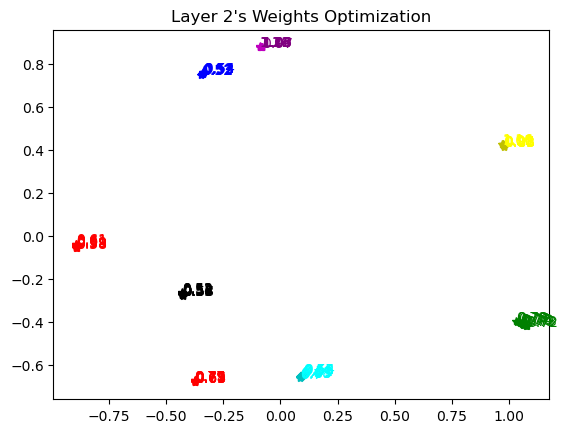

In [9]:
colorList = ['r*', 'b*', 'g*', 'm*', 'c*', 'y*', 'k*']
colorNameList = ["red", "blue", "green", "purple", "cyan", "yellow", 'black']
count = 0
colorcount = 0
for pair in layer2Reduced:
    if (count % 10) == 0 and count != 0:

        if colorcount >= len(colorList) - 1:
            colorcount = 0
        else:
            colorcount += 1
    plt.plot(pair[0], pair[1], colorList[colorcount])
    plt.annotate(str(round(costVector[count][0], 2)), (pair[0], pair[1]), color=colorNameList[colorcount])
    count += 1
plt.title("Layer 2's Weights Optimization") 
plt.show()

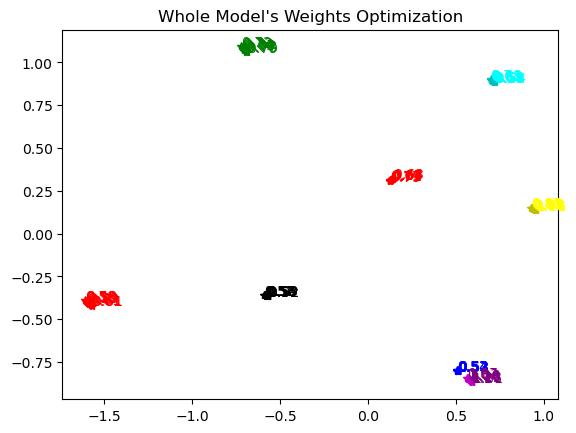

In [10]:
count = 0
colorcount = 0
for pair in wholeModelReduced:
    if (count % 10) == 0 and count != 0:
        if colorcount >= len(colorList) - 1:
            colorcount = 0
        else:
            colorcount += 1
    plt.plot(pair[0], pair[1], colorList[colorcount])
    plt.annotate(str(round(costVector[count][0], 2)), (pair[0], pair[1]), color=colorNameList[colorcount])
    count += 1
plt.title("Whole Model's Weights Optimization")
plt.show()